In [2]:
import numpy as np
from scipy.spatial import KDTree
from tqdm import tqdm, trange
import colorspace
from PIL import Image, ImageColor, ImageDraw
import sys, os
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

from multiprocessing import Pool

from unconstrained import sample_points
from draw_jm import get_adjacency, colour_graph, get_ball_pixels#, assign_cells_random_radii

## Distance between last covered point and the seed which covers it

To test the conjecture about whether one fast-growing ball covers the whole space at the coverage time, we'll measure the average distance between the last pixel to be covered and the seed which covers it (and maybe whether that seed also covers the whole space at the coverage time, which is pretty easy to check).

Since we're not drawing a picture, there's no real reason to restrict ourselves to $d=2$ here; we could do it for $d=3$ and even $d \geq 4$. Moulinec's algorithm still works perfectly well, although computing the points in each ball may be slow.

Could I speed things up by just checking the last point _on the boundary_ to be covered?

In [ ]:
from jmutils import sample_points, assign_cells_random_radii, get_overtake_times

In [3]:
n = 1000
dimension = 2
resolution = 100
repetitions = 200
exponents = np.linspace(0.5,2.5,21,endpoint=True)
PARALLEL = 10

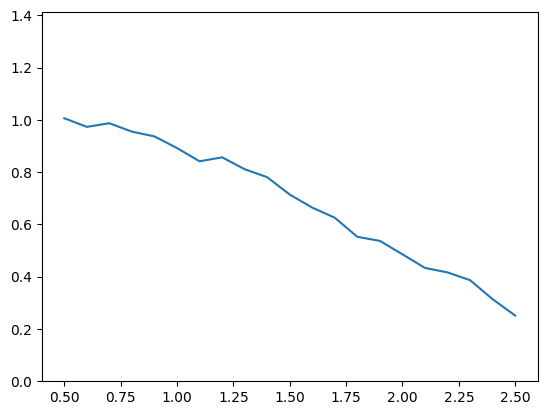

100%|█████████████████████████████████████████| 200/200 [14:25<00:00,  4.33s/it]


In [17]:
# Multiprocessing approach.
max_time = 2*np.sqrt( np.log(n) / (np.pi * n) )
distances = np.zeros_like(exponents)

def get_distance(a):
    rates = U**(-1/a)
    assignments, times = assign_cells_random_radii(seeds,rates,resolution,max_time)
    last = np.unravel_index(np.argmax(times),times.shape)
    last_location = np.array( [last[0] / (resolution-1), last[1] / (resolution-1)] )
    covered_by = assignments[last]
    return np.linalg.norm(last_location - seeds[covered_by])

def live_plot(data):
    clear_output(wait=True)
    fig,ax = plt.subplots()
    ax.plot(exponents,data)
    ax.set_ylim(0,np.sqrt(2))
    plt.show()

# progress = trange(repetitions)
for k in trange(repetitions):
    seeds = sample_points(n)
    U = np.random.random(size=seeds.shape[0]) # Random heavy-tailed radii
    # # U = np.ones(seeds.shape[0]) # We could test it with Voronoi cells - the distance should be pretty small.
    with Pool(PARALLEL) as p:
        new_distance = p.map(get_distance, exponents)
    distances += new_distance
    live_plot(distances/(k+1))
distances /= repetitions

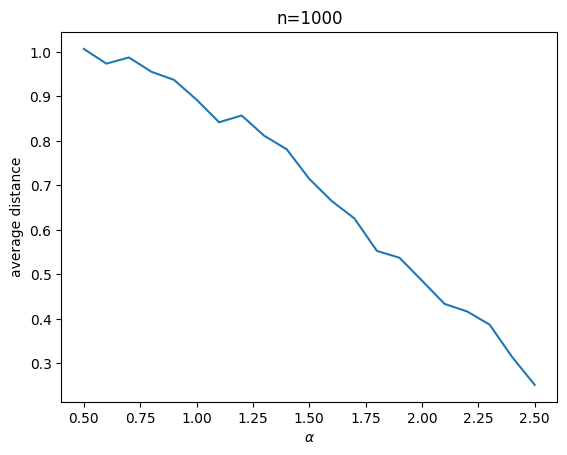

In [18]:
fig, ax = plt.subplots()
ax.plot(exponents,distances)
ax.set_title(f'n={n}')
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("average distance")
plt.savefig(f'avg-distance-n{n}.pdf')
plt.show()